### 训练中文点选验证码-类型1

使用yolo11n模型进行目标检测

使用vgg16模型训练孪生神经网络

In [1]:
import sys
import os
%matplotlib inline

# 把当前工作目录添加到sys.path中
sys.path.append(os.path.abspath(".."))
root = os.path.abspath("..")
os.makedirs(os.path.join(root, "models"), exist_ok=True)

In [ ]:
# 数据集
import my_datasets
from datasets import Dataset

dataset: Dataset = my_datasets.get_dataset("captcha_chinese_click_1")
print(dataset)

Dataset({
    features: ['image', 'objects'],
    num_rows: 451
})


#### 划分训练集和测试集

In [3]:
# 数据总共451张验证码图片，比较少，所以测试集比例选择了10%

train_test_dataset = dataset.train_test_split(test_size=0.1, shuffle=True)
train_dataset = train_test_dataset['train']
test_dataset = train_test_dataset['test']
print(train_dataset)
print(test_dataset)

Dataset({
    features: ['image', 'objects'],
    num_rows: 405
})
Dataset({
    features: ['image', 'objects'],
    num_rows: 46
})


In [4]:
print(dataset[0])

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=344x384 at 0x7FBB8B91A7B0>, 'objects': {'bbox': [[227, 4, 290, 68], [103, 78, 168, 146], [65, 221, 129, 288], [82, 349, 107, 380], [55, 347, 83, 377], [206, 213, 269, 281], [0, 348, 26, 377], [26, 348, 55, 375]], 'categories': [0, 3, 1, 0, 1, 2, 3, 2]}}


#### 数据集转换为yolo格式

In [ ]:
from PIL import Image
import os

def toYolo(dataset: Dataset, output_dir):
    # 设置输出目录的位置
    images_dir = os.path.join(output_dir, "images")  # 图片保存目录
    labels_dir = os.path.join(output_dir, "labels")  # 标签保存目录

    # 确保输出目录及其子目录存在
    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)

    for idx, data in enumerate(dataset):
        image: Image = data['image']
        objects: object = data['objects']
        bbox: list[list[int]] = objects['bbox']
        # categories: list[int] = objects['categories']

        img_width, img_height = image.size

        image_filename = str(idx) + '.jpg'
        label_filename = str(idx) + '.txt'

        image_filepath = os.path.join(images_dir, image_filename)
        label_filepath = os.path.join(labels_dir, label_filename)

        image.save(image_filepath)

        with open(label_filepath, 'w') as f:
            for idx, box in enumerate(bbox):
                x_min, y_min, x_max, y_max = box
                category = 0 # 默认类别为0
                # category = categories[idx]

                # 将边界框转换为YOLO格式：(class_id, x_center, y_center, width, height)
                x_center = (x_min + x_max) / 2 / img_width
                y_center = (y_min + y_max) / 2 / img_height
                width = (x_max - x_min) / img_width
                height = (y_max - y_min) / img_height

                # 写入标签文件，格式为：class_id x_center y_center width height
                f.write(f"{category} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")


root = os.path.abspath("..")
yolo_root = os.path.join(root, "datasets/captcha_chinese_click_1/yolo")
toYolo(dataset=train_dataset, output_dir=os.path.join(yolo_root, "train"))
toYolo(dataset=test_dataset, output_dir=os.path.join(yolo_root, "test"))

#### 训练yolo11n模型

In [6]:
from ultralytics import YOLO
import yaml

yolo11_model = YOLO(os.path.join(root, "models", "yolo11n.pt"))
train_parms = {
    "train": os.path.abspath(os.path.join(yolo_root, "train")),
    "val": os.path.abspath(os.path.join(yolo_root, "test")),
    "nc": 1,
    "names": ["text"],
}

yaml.dump(train_parms, open(os.path.join(yolo_root, "data.yaml"), "w"))

results = yolo11_model.train(
    pretrained=os.path.join(root, "models", "yolo11n.pt"),
    amp=False,  # 开启自动混合精度训练加速 需要在当前目录下载模型 明明有模型了还要下载 没搞明白为什么不能改目录
    project="captcha_chinese_click_1",
    data=os.path.join(yolo_root, "data.yaml"),
    epochs=100,
    batch=16,
    imgsz=384,
    device="cuda:0",
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/home/qsr/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Transferred 499/499 items from pretrained weights
Ultralytics 8.3.249 🚀 Python-3.13.11 torch-2.9.1+cu130 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7808MiB)
engine/trainer: agnostic_nms=False, amp=False, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/qsr/others/projects/python/CaptchaBreaker_models/datasets/captcha_chinese_click_1/yolo/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, flipl

#### 导出yolo模型

In [8]:
yolo11_model.export(
    format='onnx',
    # 动态batch_size
    dynamic=True,
    # 在模型内部开启非极大值抑制，减少后处理的计算量
    nms=True,
)

Ultralytics 8.3.249 🚀 Python-3.13.11 torch-2.9.1+cu130 CPU (AMD Ryzen 9 7945HX with Radeon Graphics)
WARNING ⚠️ 'dynamic=True' model with 'nms=True' requires max batch size, i.e. 'batch=16'
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs

PyTorch: starting from '/home/qsr/others/projects/python/CaptchaBreaker_models/captcha_chinese_click_1/captcha_chinese_click_1/train/weights/best.pt' with input shape (1, 3, 384, 384) BCHW and output shape(s) (1, 300, 6) (5.2 MB)
requirements: Ultralytics requirement ['onnxslim>=0.1.71'] not found, attempting AutoUpdate...
Looking in indexes: https://mirrors.tuna.tsinghua.edu.cn/pypi/web/simple

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [onnxslim]


requirements: AutoUpdate success ✅ 1.8s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.20.0 opset 22...


/home/qsr/.conda/envs/captcha_breaker_models/lib/python3.13/site-packages/torch/onnx/_internal/torchscript_exporter/utils.py:1447: OnnxExporterWarning: Exporting to ONNX opset version 22 is not supported. by 'torch.onnx.export()'. The highest opset version supported is 20. To use a newer opset version, consider 'torch.onnx.export(..., dynamo=True)'. 
  warnings.warn(


ONNX: slimming with onnxslim 0.1.82...
ONNX: export success ✅ 3.4s, saved as '/home/qsr/others/projects/python/CaptchaBreaker_models/captcha_chinese_click_1/captcha_chinese_click_1/train/weights/best.onnx' (10.8 MB)

Export complete (3.5s)
Results saved to /home/qsr/others/projects/python/CaptchaBreaker_models/captcha_chinese_click_1/captcha_chinese_click_1/train/weights
Predict:         yolo predict task=detect model=/home/qsr/others/projects/python/CaptchaBreaker_models/captcha_chinese_click_1/captcha_chinese_click_1/train/weights/best.onnx imgsz=384  
Validate:        yolo val task=detect model=/home/qsr/others/projects/python/CaptchaBreaker_models/captcha_chinese_click_1/captcha_chinese_click_1/train/weights/best.onnx imgsz=384 data=/home/qsr/others/projects/python/CaptchaBreaker_models/datasets/captcha_chinese_click_1/yolo/data.yaml  
Visualize:       https://netron.app


'/home/qsr/others/projects/python/CaptchaBreaker_models/captcha_chinese_click_1/captcha_chinese_click_1/train/weights/best.onnx'

### 孪生神经网络(其实就是VGG16啦)

简单说一下原理，其实就是 先提取图像的特征，展平出一维特征图，然后求两个特征图之间的欧式距离。

每条训练数据有三个样本，分别为基样本，正向激励样本，反向激励样本

基样本和正向激励样本是同一个文字，反向激励样本是另一个文字

那么loss的规则就是，基样本和正向激励样本距离越大loss越大，基样本和反向激励样本距离越大loss越小

详情请搜索Triplet Loss

In [9]:
from torch import nn
from torchvision import models, transforms
import torch


class SiameseNet(nn.Module):

    def __init__(self):
        super(SiameseNet, self).__init__()
        # 用了ImageNet上的预训练权重，所以输入的时候要进行标准化
        vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_FEATURES)
        # 把vgg16的平均池化层和分类层去掉, 只保留特征提取层
        del vgg16.classifier
        del vgg16.avgpool
        self.features = vgg16.features
        # 把ImageNet标准化放在模型内部，省得后期调用时再写
        # 输入图片的像素范围是0-255，需要归一化到0-1
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])

    # 简单吧
    def forward(self, x):
        x = self.normalize(x)
        x = self.features(x)
        # 展平特征图(从第1维开始，因为第0维是batch_size)
        x = torch.flatten(x, start_dim=1)
        return x

### 数据集

In [10]:
import random
from matplotlib import pyplot as plt


class SiameseDataset(torch.utils.data.Dataset):
    def __init__(self, dataset: Dataset, transform=None):
        """
        Args:
            dataset (Dataset): 包含验证码数据的原始数据集。
            transform (callable, optional): 可选的图像变换方法。
        """
        self.transform = transform
        self.triplets = []  # 存储所有三元组（已裁剪但未应用变换）

        # 遍历原始数据集，生成所有三元组
        for data in dataset:
            image = data['image']  # PIL 图像
            objects = data['objects']
            bboxes = objects['bbox']  # 边界框列表
            categories = objects['categories']  # 分类标签列表

            # 分离题目框和答案框
            question_boxes = [box for box in bboxes if box[1] >= 344]  # y_min >= 344
            answer_boxes = [box for box in bboxes if box[1] < 344]  # y_min < 344

            # 构建类别映射
            category_map = {}
            for i, category in enumerate(categories):
                if category not in category_map:
                    category_map[category] = []
                category_map[category].append(bboxes[i])

            # 遍历每个题目框，生成三元组
            for anchor_box in question_boxes:
                anchor_category = categories[bboxes.index(anchor_box)]  # 基准样本的类别
                positive_boxes = category_map[anchor_category]  # 激励样本（与基准样本同类别）
                positive_boxes = [box for box in positive_boxes if box != anchor_box]
                
                # 如果没有正样本，跳过
                if not positive_boxes:
                    continue

                # 负面样本：从不同类别的答案框中选择
                negative_boxes = [
                    box for i, box in enumerate(answer_boxes)
                    if categories[bboxes.index(box)] != anchor_category
                ]

                # 如果没有负样本，跳过
                if not negative_boxes:
                    continue

                # 随机选择一个正样本和一个负样本
                positive_box = random.choice(positive_boxes)
                negative_box = random.choice(negative_boxes)

                # 裁剪图片
                anchor_image = image.crop(anchor_box)  # 基准样本
                positive_image = image.crop(positive_box)  # 激励样本
                negative_image = image.crop(negative_box)  # 负面样本

                # 存储三元组（已裁剪但未应用变换）
                self.triplets.append((anchor_image, positive_image, negative_image))

    def __getitem__(self, index):
        """
        根据索引获取一组三张图片：基准样本、激励样本和负面样本。
        """
        # 获取存储的三元组信息
        anchor_image, positive_image, negative_image = self.triplets[index]

        # 应用变换
        if self.transform:
            anchor_image = self.transform(anchor_image)
            positive_image = self.transform(positive_image)
            negative_image = self.transform(negative_image)

        return anchor_image, positive_image, negative_image

    def __len__(self):
        return len(self.triplets)
    


    def preview(self, num_samples=5):
        """
        随机预览数据集中的若干条数据。
        
        Args:
            num_samples (int): 要预览的样本数量，默认为5。
        """
        # 随机选择若干索引
        indices = random.sample(range(len(self)), num_samples)

        # 创建画布
        fig, axes = plt.subplots(num_samples, 3, figsize=(10, 3 * num_samples))
        if num_samples == 1:
            axes = [axes]  # 单一样本时调整形状

        for i, idx in enumerate(indices):
            # 获取三元组
            anchor, positive, negative = self[idx]

            # 将 Tensor 转换为 PIL 图像（如果需要）
            if isinstance(anchor, torch.Tensor):
                anchor = transforms.ToPILImage()(anchor)
                positive = transforms.ToPILImage()(positive)
                negative = transforms.ToPILImage()(negative)

            # 显示图像
            axes[i][0].imshow(anchor)
            axes[i][0].set_title("Anchor")
            axes[i][0].axis('off')

            axes[i][1].imshow(positive)
            axes[i][1].set_title("Positive")
            axes[i][1].axis('off')

            axes[i][2].imshow(negative)
            axes[i][2].set_title("Negative")
            axes[i][2].axis('off')

        plt.tight_layout()
        plt.show()
    

transform = transforms.Compose([
    transforms.Resize((96, 96)),  # 调整图像大小
    transforms.ToTensor(),  # 转换为张量
    transforms.RandomRotation(10),  # 随机旋转，最大角度为 10 度
    transforms.RandomHorizontalFlip(), # 随机水平翻转
    transforms.RandomVerticalFlip(), # 随机垂直翻转
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1), # 随机颜色抖动
])

In [11]:
siamese_dataset_train = SiameseDataset(dataset=train_dataset, transform=transform)
siamese_dataset_test = SiameseDataset(dataset=test_dataset, transform=transform)
print(len(siamese_dataset_train))
print(len(siamese_dataset_test))

1208
139


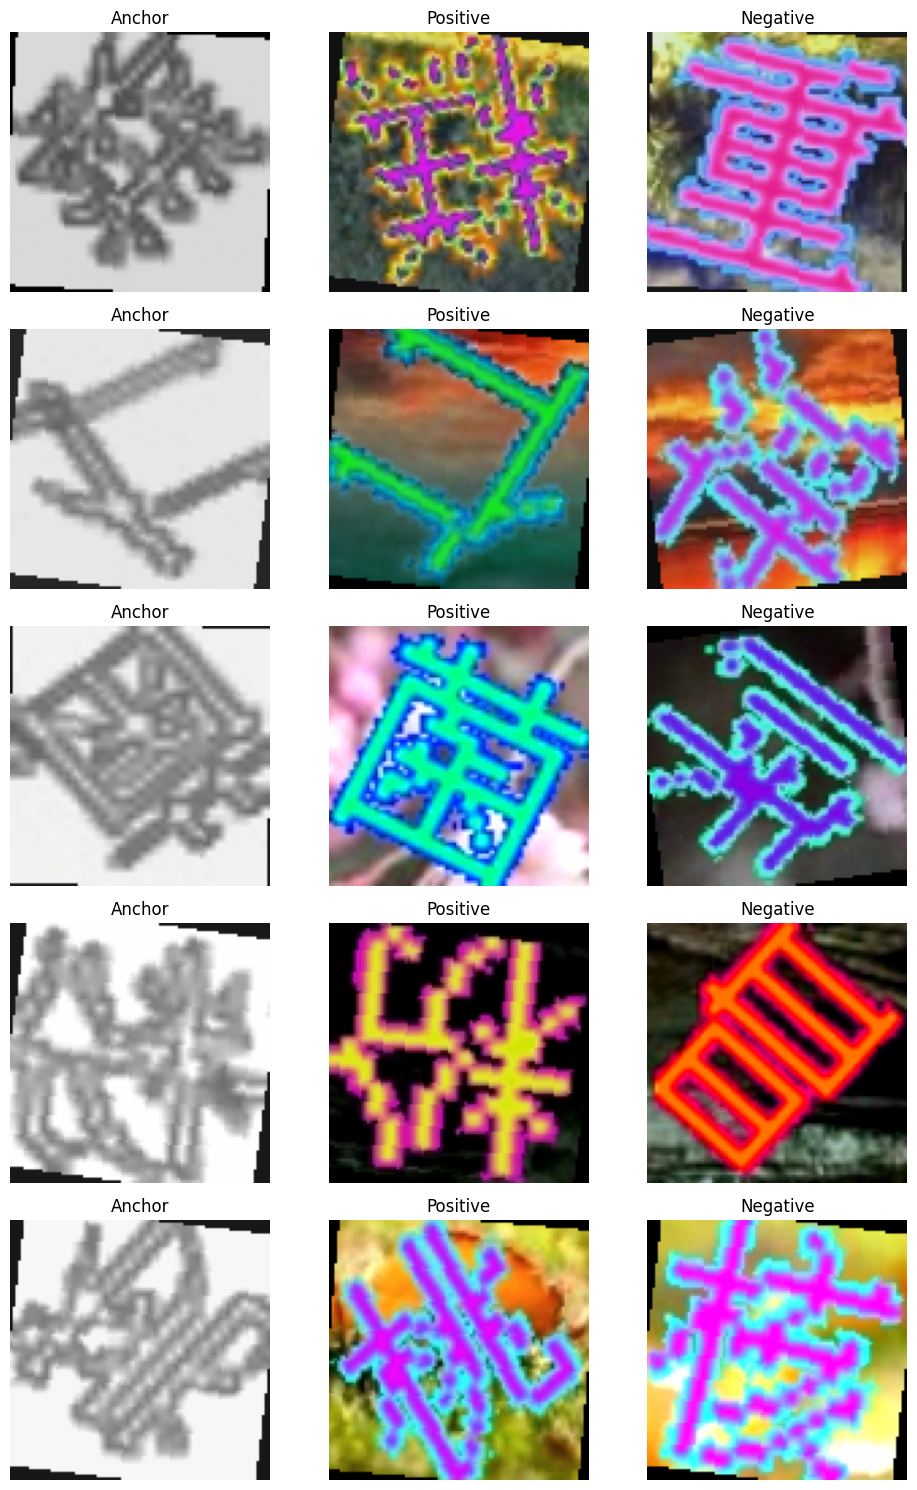

In [12]:
# 预览数据集
siamese_dataset_train.preview()

### 模型训练器

In [13]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Trainer:
    def __init__(self, model, train_loader, val_loader, device=device):
        self.model = model.to(device)
        self.device = device
        self.train_loader = train_loader
        self.val_loader = val_loader
        
        self.loss = nn.TripletMarginLoss(margin=2.0)
        self.optimizer = optim.AdamW(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=0.0001,
            weight_decay=0.5
        )
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer, T_max=20
        )
        
    def train_epoch(self, epoch):
        self.model.train()
        total_loss = 0.0
        
        for batch_idx, (a, p, n) in enumerate(self.train_loader):
            a,p,n = a.to(self.device), p.to(self.device), n.to(self.device)
            
            self.optimizer.zero_grad()
            a_features = self.model(a)
            p_features = self.model(p)
            n_features = self.model(n)
            loss = self.loss(a_features, p_features, n_features)
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 5.0)
            self.optimizer.step()
            
            total_loss += loss.item()
            if batch_idx % 10 == 9:
                print(f'迭代轮次: {epoch} | 批次: {batch_idx+1} | 损失: {total_loss/10:.4f}')
                total_loss = 0.0
                
        return loss.item()
    
    def validate(self):
        self.model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for a, p, n in self.val_loader:
                a, p, n = a.to(self.device), p.to(self.device), n.to(self.device)
                
                # 提取特征
                a_features = self.model(a)
                p_features = self.model(p)
                n_features = self.model(n)
                
                # 计算损失
                loss = self.loss(a_features, p_features, n_features)
                val_loss += loss.item()
                
                # 使用距离判断分类正确性
                pos_dist = torch.norm(a_features - p_features, dim=1)  # 正样本对的距离
                neg_dist = torch.norm(a_features - n_features, dim=1)  # 负样本对的距离
                
                # 如果正样本距离小于负样本距离，则认为预测正确
                correct += (pos_dist < neg_dist).sum().item()
                total += a.size(0)
    
        avg_loss = val_loss / len(self.val_loader)
        accuracy = correct / total
        print(f'验证集损失: {avg_loss:.4f} | 验证集正确率: {accuracy:.4f}')
        return avg_loss, accuracy

#### 训练模型

In [14]:
from torch.utils.data import DataLoader
root = os.path.abspath("..")
epochs = 300

train_loader = DataLoader(siamese_dataset_train, batch_size=24, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(siamese_dataset_test, batch_size=24, shuffle=False, num_workers=4, pin_memory=True)

# 初始化模型
model = SiameseNet()
# 加载参数
# model.load_state_dict(torch.load(os.path.join(root, "models", "loss0.0000_acc0.0000_chinese_click_1.pt")))
trainer = Trainer(model, train_loader, val_loader)

# 训练循环（保持不变）


min_loss = 1e9
for epoch in range(1, epochs + 1):
    print(f"迭代 {epoch}/{epochs}:")
    train_loss = trainer.train_epoch(epoch)
    val_loss, val_acc = trainer.validate()
    
    trainer.scheduler.step()
    
    if val_loss < min_loss:
        min_loss = val_loss
        torch.save(model.state_dict(), os.path.join(root, "models", f"loss{val_loss:4f}_acc{val_acc:4f}_chinese_click_1.pt"))
        print(f"保存最优模型, 最新的损失: {val_loss:.4f}")

Downloading: "https://download.pytorch.org/models/vgg16_features-amdegroot-88682ab5.pth" to /home/qsr/.cache/torch/hub/checkpoints/vgg16_features-amdegroot-88682ab5.pth


100%|██████████| 528M/528M [00:53<00:00, 10.4MB/s]  


迭代 1/300:
迭代轮次: 1 | 批次: 10 | 损失: 2.0505
迭代轮次: 1 | 批次: 20 | 损失: 1.7851
迭代轮次: 1 | 批次: 30 | 损失: 1.9440
迭代轮次: 1 | 批次: 40 | 损失: 1.6904
迭代轮次: 1 | 批次: 50 | 损失: 1.5680
验证集损失: 1.5805 | 验证集正确率: 0.6763
保存最优模型, 最新的损失: 1.5805
迭代 2/300:
迭代轮次: 2 | 批次: 10 | 损失: 1.1884
迭代轮次: 2 | 批次: 20 | 损失: 1.1836
迭代轮次: 2 | 批次: 30 | 损失: 1.3694
迭代轮次: 2 | 批次: 40 | 损失: 1.0753
迭代轮次: 2 | 批次: 50 | 损失: 1.6059
验证集损失: 1.3230 | 验证集正确率: 0.7050
保存最优模型, 最新的损失: 1.3230
迭代 3/300:
迭代轮次: 3 | 批次: 10 | 损失: 1.1973
迭代轮次: 3 | 批次: 20 | 损失: 1.0029
迭代轮次: 3 | 批次: 30 | 损失: 1.0268
迭代轮次: 3 | 批次: 40 | 损失: 1.4346
迭代轮次: 3 | 批次: 50 | 损失: 1.4014
验证集损失: 1.1436 | 验证集正确率: 0.7410
保存最优模型, 最新的损失: 1.1436
迭代 4/300:
迭代轮次: 4 | 批次: 10 | 损失: 1.3875
迭代轮次: 4 | 批次: 20 | 损失: 0.8877
迭代轮次: 4 | 批次: 30 | 损失: 1.2227
迭代轮次: 4 | 批次: 40 | 损失: 1.1155
迭代轮次: 4 | 批次: 50 | 损失: 1.2509
验证集损失: 0.9607 | 验证集正确率: 0.7698
保存最优模型, 最新的损失: 0.9607
迭代 5/300:
迭代轮次: 5 | 批次: 10 | 损失: 1.0690
迭代轮次: 5 | 批次: 20 | 损失: 0.8527
迭代轮次: 5 | 批次: 30 | 损失: 1.1136
迭代轮次: 5 | 批次: 40 | 损失: 1.1431
迭代轮次: 5 | 批次: 50 |

#### 导出模型为onnx

In [ ]:
import onnx

model = SiameseNet()

# 把路径更改为你保存的模型路径
model.load_state_dict(torch.load('../models/loss0.194566_acc0.964029_chinese_click_1.pt'))

dummy_input = torch.randn(1, 3, 96, 96)

torch.onnx.export(
    model,
    dummy_input,
    "../models/siamese.onnx",
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'}
    },
    dynamo=False
)

/tmp/ipykernel_121177/2654259081.py:10: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(
W0108 02:27:11.122000 121177 site-packages/torch/fx/experimental/symbolic_shapes.py:7942] Unable to find user code corresponding to {u0}


[torch.onnx] Obtain model graph for `SiameseNet([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `SiameseNet([...]` with `torch.export.export(..., strict=False)`... ❌
[torch.onnx] Obtain model graph for `SiameseNet([...]` with `torch.export.export(..., strict=True)`...





def forward(self, arg0_1: "f32[64, 3, 3, 3]", arg1_1: "f32[64]", arg2_1: "f32[64, 64, 3, 3]", arg3_1: "f32[64]", arg4_1: "f32[128, 64, 3, 3]", arg5_1: "f32[128]", arg6_1: "f32[128, 128, 3, 3]", arg7_1: "f32[128]", arg8_1: "f32[256, 128, 3, 3]", arg9_1: "f32[256]", arg10_1: "f32[256, 256, 3, 3]", arg11_1: "f32[256]", arg12_1: "f32[256, 256, 3, 3]", arg13_1: "f32[256]", arg14_1: "f32[512, 256, 3, 3]", arg15_1: "f32[512]", arg16_1: "f32[512, 512, 3, 3]", arg17_1: "f32[512]", arg18_1: "f32[512, 512, 3, 3]", arg19_1: "f32[512]", arg20_1: "f32[512, 512, 3, 3]", arg21_1: "f32[512]", arg22_1: "f32[512, 512, 3, 3]", arg23_1: "f32[512]", arg24_1: "f32[512, 512, 3, 3]", arg25_1: "f32[512]", arg26_1: "f32[s77, 3, 96, 96]"):
     # File: /home/qsr/.conda/envs/captcha_breaker_models/lib/python3.13/site-packages/torchvision/transforms/transforms.py:277 in forward, code: return F.normalize(tensor, self.mean, self.std, self.inplace)
    clone: "f32[s77, 3, 96, 96]" = torch.ops.aten.clone.default(arg

[torch.onnx] Obtain model graph for `SiameseNet([...]` with `torch.export.export(..., strict=True)`... ❌


TorchExportError: Failed to export the model with torch.export. [96mThis is step 1/3[0m of exporting the model to ONNX. Next steps:
- Modify the model code for `torch.export.export` to succeed. Refer to https://pytorch.org/docs/stable/generated/exportdb/index.html for more information.
- Debug `torch.export.export` and submit a PR to PyTorch.
- Create an issue in the PyTorch GitHub repository against the [96m*torch.export*[0m component and attach the full error stack as well as reproduction scripts.

## Exception summary

<class 'torch.fx.experimental.symbolic_shapes.GuardOnDataDependentSymNode'>: Could not guard on data-dependent expression Eq(u0, 1) (unhinted: Eq(u0, 1)).  (Size-like symbols: none)

consider using data-dependent friendly APIs such as guard_or_false, guard_or_true and statically_known_trueCaused by: (_export/non_strict_utils.py:1066 in __torch_function__)
For more information, run with TORCH_LOGS="dynamic"
For extended logs when we create symbols, also add TORCHDYNAMO_EXTENDED_DEBUG_CREATE_SYMBOL="u0"
If you suspect the guard was triggered from C++, add TORCHDYNAMO_EXTENDED_DEBUG_CPP=1
For more debugging help, see https://docs.google.com/document/d/1HSuTTVvYH1pTew89Rtpeu84Ht3nQEFTYhAX3Ypa_xJs/edit?usp=sharing

For C++ stack trace, run with TORCHDYNAMO_EXTENDED_DEBUG_CPP=1

The following call raised this error:
  File "/home/qsr/.conda/envs/captcha_breaker_models/lib/python3.13/site-packages/torchvision/transforms/_functional_tensor.py", line 922, in normalize
    if (std == 0).any():


The error above occurred when calling torch.export.export. If you would like to view some more information about this error, and get a list of all other errors that may occur in your export call, you can replace your `export()` call with `draft_export()`.

(Refer to the full stack trace above for more information.)